In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(399)

popcorn = range(12)
people = range(80)
num_matchups = 1000
person_id_1 = np.random.choice(people, num_matchups)
person_id_2 = np.random.choice(people, num_matchups)
popcorn_id_1 = np.random.choice(popcorn, num_matchups)
popcorn_id_2 = np.random.choice(popcorn, num_matchups)



with pm.Model(coords={"popcorn": popcorn, "people": people}) as model:
    mu_popcorn = pm.ZeroSumNormal("mu_popcorn", sigma=1, dims="popcorn")
    person_popcorn_interaction = pm.ZeroSumNormal("person_popcorn_interaction", sigma=0.3, dims=["people", "popcorn"])

    popcorn_rating = pm.Normal("popcorn_rating", mu=mu_popcorn + person_popcorn_interaction, sigma=0.2, dims=["people", "popcorn"])

    rating_diff = pm.Deterministic("rating_diff", popcorn_rating[person_id_1, popcorn_id_1] - popcorn_rating[person_id_2, popcorn_id_2])

In [2]:
with model:
    prior_predictive_trace = pm.sample_prior_predictive(100)

Sampling: [mu_popcorn, person_popcorn_interaction, popcorn_rating]


In [11]:
blind_a = {"a": 2, "b": 3, "c": 1, "d": 4}
blind_a = {v: k for k, v in blind_a.items()}
blind_b = {"a": "default", "b": "latmask", "c": "ugn", "d": "smör"}
decoding = {k: blind_b[v] for k, v in blind_a.items()}
decoding

{2: 'default', 3: 'latmask', 1: 'ugn', 4: 'smör'}

array([[<Axes: title={'center': 'rating_diff'}>,
        <Axes: title={'center': 'rating_diff'}>],
       [<Axes: title={'center': 'person_popcorn_interaction'}>,
        <Axes: title={'center': 'person_popcorn_interaction'}>],
       [<Axes: title={'center': 'mu_popcorn'}>,
        <Axes: title={'center': 'mu_popcorn'}>],
       [<Axes: title={'center': 'popcorn_rating'}>,
        <Axes: title={'center': 'popcorn_rating'}>]], dtype=object)

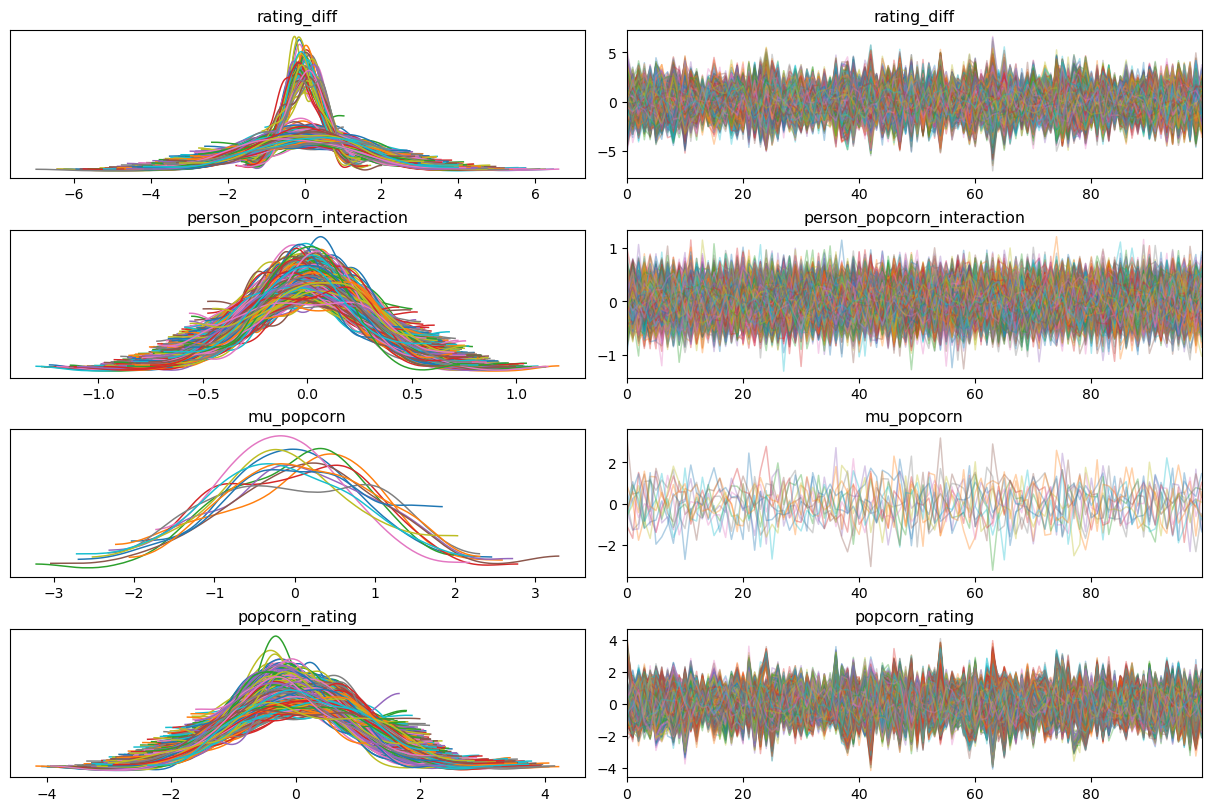

In [3]:
import arviz as az
az.plot_trace(prior_predictive_trace.prior)

In [4]:
a = np.random.randint(10, size=(5,4))
print(a)
a[[0,1], [2, 3]]

[[6 3 2 6]
 [4 7 3 1]
 [4 9 9 2]
 [6 8 9 6]
 [6 8 1 1]]


array([2, 1])

In [5]:
sample = prior_predictive_trace.prior.sel(chain=0, draw=0)
synthetic_df = pd.DataFrame(
    {
        "person_1": person_id_1,
        "person_2": person_id_2,
        "popcorn_1": popcorn_id_1,
        "popcorn_2": popcorn_id_2,
        "rating_diff": np.round(sample["rating_diff"])
    }
)
synthetic_popcorn_ratings = sample["popcorn_rating"]

synthetic_df.head()

,person_1,person_2,popcorn_1,popcorn_2,rating_diff
0,78,48,10,4,1.0
1,71,31,5,8,4.0
2,70,68,7,9,1.0
3,21,26,5,10,4.0
4,35,18,8,5,-5.0


In [27]:
from utils import read_table
df = read_table()
df["rating_diff"] = df["score"]
df = df[df["popcorn_id_1"] != "10"]
df["popcorn_1"] = [decoding[int(id_)] for id_ in df["popcorn_id_1"]]
df["popcorn_2"] = [decoding[int(id_)] for id_ in df["popcorn_id_2"]]
df

,event_uid,user_uid,popcorn_id_1,popcorn_id_2,score,timestamp,rating_diff,popcorn_1,popcorn_2
1,2,LOK,1,2,-1.110,1712344214,-1.110,ugn,default
2,3,AMC,1,2,1.000,1712344232,1.000,ugn,default
3,4,Ifk,2,4,1.225,1712344244,1.225,default,smör
4,5,AMC,1,3,1.000,1712344263,1.000,ugn,latmask
5,6,RRR,1,2,-2.000,1712344265,-2.000,ugn,default
6,7,LOK,3,4,-0.992,1712344276,-0.992,latmask,smör
7,8,AMC,1,4,1.957,1712344291,1.957,ugn,smör
8,9,Ifk,1,3,0.932,1712344306,0.932,ugn,latmask
9,10,LOK,2,4,1.044,1712344314,1.044,default,smör
10,11,atg,3,1,-0.966,1712344321,-0.966,latmask,ugn


In [37]:
popcorn = list(df["popcorn_1"].unique())
people = list(df["user_uid"].unique())
people

['LOK', 'AMC', 'Ifk', 'RRR', 'atg', 'EJA', 'Bob']

In [41]:
person_indices = [people.index(p) for p in df["user_uid"]]
popcorn_1_indices = [popcorn.index(p) for p in df["popcorn_1"]]
popcorn_2_indices = [popcorn.index(p) for p in df["popcorn_2"]]

In [48]:
with pm.Model(coords={"popcorn": popcorn, "people": people}) as model:
    mu_popcorn = pm.ZeroSumNormal("mu_popcorn", sigma=1, dims="popcorn")
    person_popcorn_interaction = pm.ZeroSumNormal("person_popcorn_interaction", sigma=0.3, dims=["people", "popcorn"])

    popcorn_rating = pm.Normal("popcorn_rating", mu=mu_popcorn + person_popcorn_interaction, sigma=0.2, dims=["people", "popcorn"])


    rating_diff = pm.Deterministic("rating_diff", popcorn_rating[person_indices, popcorn_2_indices] - popcorn_rating[person_indices, popcorn_1_indices])
    observed_rating_diff = pm.Normal("observed_rating_diff", mu=rating_diff, sigma=0.3, observed=df["rating_diff"])

In [49]:
with model:
    trace = pm.sample(1000, tune=1000)

# az.plot_trace(trace, coords={"popcorn": [0, 1, 2, 3, 4, 5], "people": [0, 1, 2, 3, 4, 5]})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_popcorn, person_popcorn_interaction, popcorn_rating]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/root/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'popcorn_rating'}>,
        <Axes: title={'center': 'popcorn_rating'}>],
       [<Axes: title={'center': 'mu_popcorn'}>,
        <Axes: title={'center': 'mu_popcorn'}>],
       [<Axes: title={'center': 'person_popcorn_interaction'}>,
        <Axes: title={'center': 'person_popcorn_interaction'}>],
       [<Axes: title={'center': 'rating_diff'}>,
        <Axes: title={'center': 'rating_diff'}>]], dtype=object)

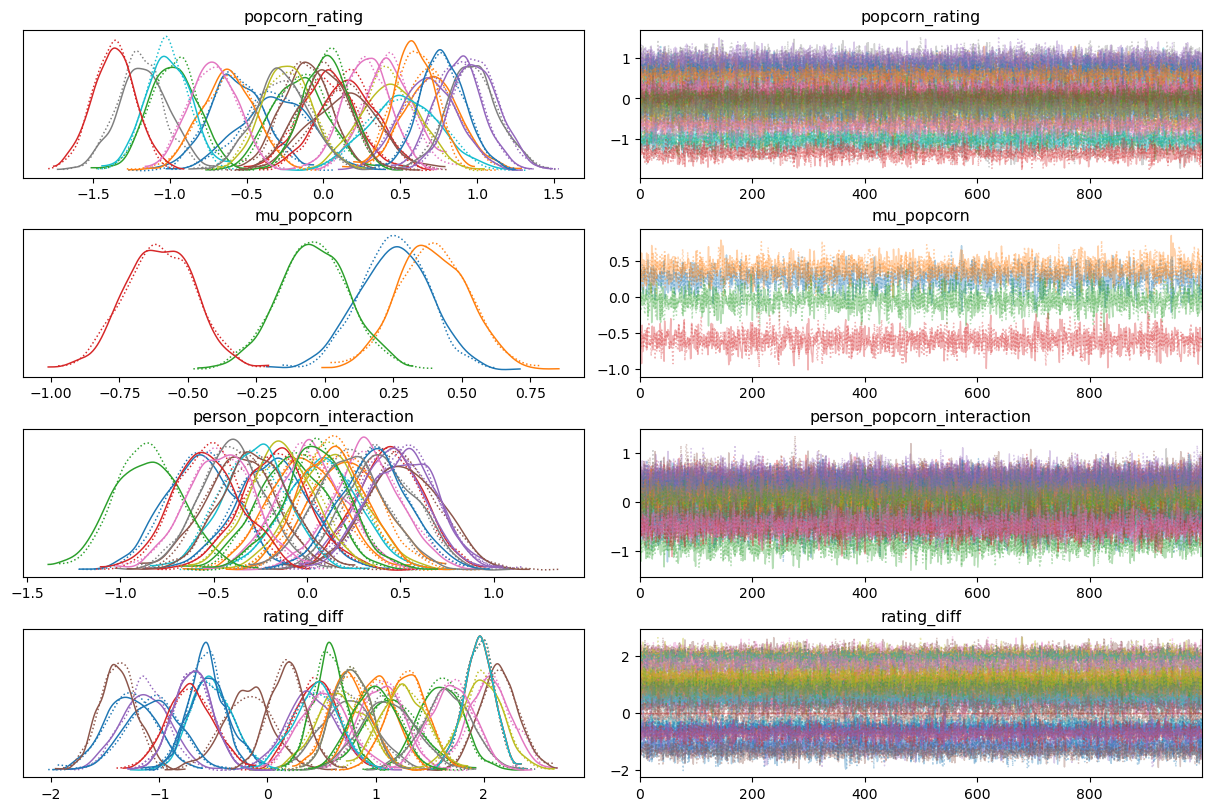

In [45]:
az.plot_trace(trace)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

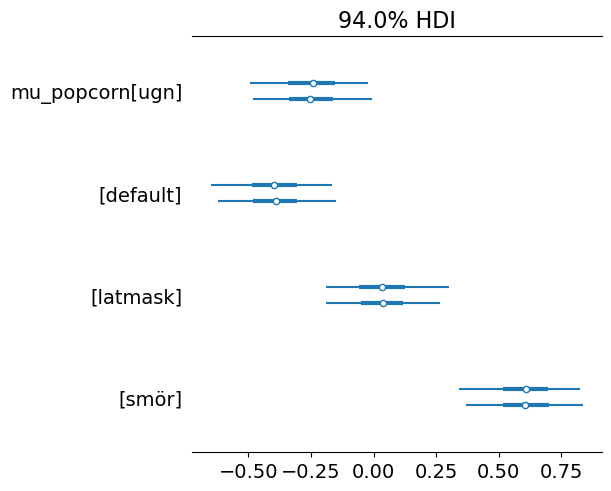

In [50]:
az.plot_forest(trace, var_names=["mu_popcorn"])


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

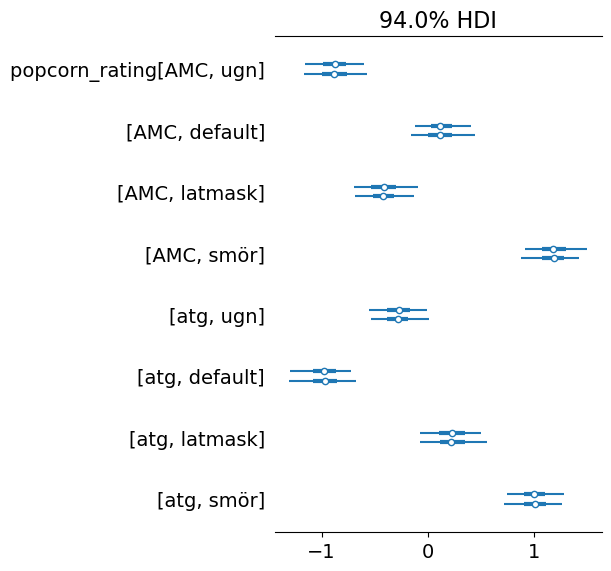

In [52]:
az.plot_forest(trace, var_names=["popcorn_rating"], coords={"people":["AMC", "atg"]})

In [ ]:
trace

In [ ]:
import matplotlib.pyplot as plt

# Example data (point estimates and confidence intervals)
parameters = ['Parameter 1', 'Parameter 2', 'Parameter 3', 'Parameter 4']
point_estimates = [10, 15, 20, 25]
confidence_intervals = [(8, 12), (12, 18), (18, 22), (22, 28)]  # Example confidence intervals

# Calculate summary statistics (e.g., mean or median of point estimates)
summary_statistics = dict(zip(parameters, point_estimates))

# Order parameters based on summary statistics
ordered_parameters = sorted(parameters, key=lambda x: summary_statistics[x], reverse=True)

# Plot forest plot
plt.figure(figsize=(8, 6))
for i, param in enumerate(ordered_parameters):
    plt.plot([confidence_intervals[i][0], confidence_intervals[i][1]], [i, i], marker='o', linestyle='-')
    plt.plot(summary_statistics[param], i, 'ko')  # Plot point estimates
plt.yticks(range(len(ordered_parameters)), ordered_parameters)
plt.xlabel('Parameter Value')
plt.title('Forest Plot of Parameters')
plt.grid(True)
plt.show()
